In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Importing Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


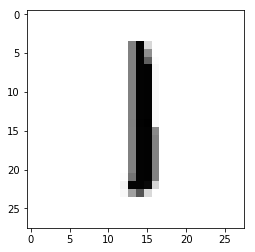

In [5]:
plt.imshow(mnist.train.images[12].reshape(28,28), cmap='Greys')

# The Generator

In [6]:
def generator(z,reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        #leaky Relu
        alpha=0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        return output

# The Discriminator

In [7]:
def discriminator(X, reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X, units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        
        return output, logits

# Placeholders

In [8]:
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

# Generator

In [9]:
G = generator(z)

# Discriminator

In [10]:
D_output_real , D_logits_real = discriminator(real_images)

In [11]:
D_output_fake , D_logits_fake = discriminator(G, reuse=True)

# Losses

In [12]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

In [13]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*(0.9))

In [14]:
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

In [15]:
D_loss = D_real_loss + D_fake_loss

In [16]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

# Optimizers

In [17]:
learning_rate = 0.001

In [18]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print ([v.name for v in d_vars])
print ([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [19]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [20]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

# Training Session

In [21]:
batch_size = 100
epochs = 1000
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [22]:
# Save a sample per epoch
samples = []

In [23]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 -1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z , reuse=True), feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
        saver.save(sess, './models/500_epoch_model.ckpt')        

Currently on Epoch 1 of 1000 total...
Currently on Epoch 2 of 1000 total...
Currently on Epoch 3 of 1000 total...
Currently on Epoch 4 of 1000 total...
Currently on Epoch 5 of 1000 total...
Currently on Epoch 6 of 1000 total...
Currently on Epoch 7 of 1000 total...
Currently on Epoch 8 of 1000 total...
Currently on Epoch 9 of 1000 total...
Currently on Epoch 10 of 1000 total...
Currently on Epoch 11 of 1000 total...
Currently on Epoch 12 of 1000 total...
Currently on Epoch 13 of 1000 total...
Currently on Epoch 14 of 1000 total...
Currently on Epoch 15 of 1000 total...
Currently on Epoch 16 of 1000 total...
Currently on Epoch 17 of 1000 total...
Currently on Epoch 18 of 1000 total...
Currently on Epoch 19 of 1000 total...
Currently on Epoch 20 of 1000 total...
Currently on Epoch 21 of 1000 total...
Currently on Epoch 22 of 1000 total...
Currently on Epoch 23 of 1000 total...
Currently on Epoch 24 of 1000 total...
Currently on Epoch 25 of 1000 total...
Currently on Epoch 26 of 1000 tota

Currently on Epoch 209 of 1000 total...
Currently on Epoch 210 of 1000 total...
Currently on Epoch 211 of 1000 total...
Currently on Epoch 212 of 1000 total...
Currently on Epoch 213 of 1000 total...
Currently on Epoch 214 of 1000 total...
Currently on Epoch 215 of 1000 total...
Currently on Epoch 216 of 1000 total...
Currently on Epoch 217 of 1000 total...
Currently on Epoch 218 of 1000 total...
Currently on Epoch 219 of 1000 total...
Currently on Epoch 220 of 1000 total...
Currently on Epoch 221 of 1000 total...
Currently on Epoch 222 of 1000 total...
Currently on Epoch 223 of 1000 total...
Currently on Epoch 224 of 1000 total...
Currently on Epoch 225 of 1000 total...
Currently on Epoch 226 of 1000 total...
Currently on Epoch 227 of 1000 total...
Currently on Epoch 228 of 1000 total...
Currently on Epoch 229 of 1000 total...
Currently on Epoch 230 of 1000 total...
Currently on Epoch 231 of 1000 total...
Currently on Epoch 232 of 1000 total...
Currently on Epoch 233 of 1000 total...


Currently on Epoch 414 of 1000 total...
Currently on Epoch 415 of 1000 total...
Currently on Epoch 416 of 1000 total...
Currently on Epoch 417 of 1000 total...
Currently on Epoch 418 of 1000 total...
Currently on Epoch 419 of 1000 total...
Currently on Epoch 420 of 1000 total...
Currently on Epoch 421 of 1000 total...
Currently on Epoch 422 of 1000 total...
Currently on Epoch 423 of 1000 total...
Currently on Epoch 424 of 1000 total...
Currently on Epoch 425 of 1000 total...
Currently on Epoch 426 of 1000 total...
Currently on Epoch 427 of 1000 total...
Currently on Epoch 428 of 1000 total...
Currently on Epoch 429 of 1000 total...
Currently on Epoch 430 of 1000 total...
Currently on Epoch 431 of 1000 total...
Currently on Epoch 432 of 1000 total...
Currently on Epoch 433 of 1000 total...
Currently on Epoch 434 of 1000 total...
Currently on Epoch 435 of 1000 total...
Currently on Epoch 436 of 1000 total...
Currently on Epoch 437 of 1000 total...
Currently on Epoch 438 of 1000 total...


Currently on Epoch 619 of 1000 total...
Currently on Epoch 620 of 1000 total...
Currently on Epoch 621 of 1000 total...
Currently on Epoch 622 of 1000 total...
Currently on Epoch 623 of 1000 total...
Currently on Epoch 624 of 1000 total...
Currently on Epoch 625 of 1000 total...
Currently on Epoch 626 of 1000 total...
Currently on Epoch 627 of 1000 total...
Currently on Epoch 628 of 1000 total...
Currently on Epoch 629 of 1000 total...
Currently on Epoch 630 of 1000 total...
Currently on Epoch 631 of 1000 total...
Currently on Epoch 632 of 1000 total...
Currently on Epoch 633 of 1000 total...
Currently on Epoch 634 of 1000 total...
Currently on Epoch 635 of 1000 total...
Currently on Epoch 636 of 1000 total...
Currently on Epoch 637 of 1000 total...
Currently on Epoch 638 of 1000 total...
Currently on Epoch 639 of 1000 total...
Currently on Epoch 640 of 1000 total...
Currently on Epoch 641 of 1000 total...
Currently on Epoch 642 of 1000 total...
Currently on Epoch 643 of 1000 total...


Currently on Epoch 824 of 1000 total...
Currently on Epoch 825 of 1000 total...
Currently on Epoch 826 of 1000 total...
Currently on Epoch 827 of 1000 total...
Currently on Epoch 828 of 1000 total...
Currently on Epoch 829 of 1000 total...
Currently on Epoch 830 of 1000 total...
Currently on Epoch 831 of 1000 total...
Currently on Epoch 832 of 1000 total...
Currently on Epoch 833 of 1000 total...
Currently on Epoch 834 of 1000 total...
Currently on Epoch 835 of 1000 total...
Currently on Epoch 836 of 1000 total...
Currently on Epoch 837 of 1000 total...
Currently on Epoch 838 of 1000 total...
Currently on Epoch 839 of 1000 total...
Currently on Epoch 840 of 1000 total...
Currently on Epoch 841 of 1000 total...
Currently on Epoch 842 of 1000 total...
Currently on Epoch 843 of 1000 total...
Currently on Epoch 844 of 1000 total...
Currently on Epoch 845 of 1000 total...
Currently on Epoch 846 of 1000 total...
Currently on Epoch 847 of 1000 total...
Currently on Epoch 848 of 1000 total...


In [ ]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    #saver.restore(sess,'./models/1000_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

In [ ]:
plt.imshow(samples[0].reshape(28,28),cmap='Greys')